# Transcription factor dependence analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm

import os
import pickle as pkl
%matplotlib inline

In [2]:
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 500)

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'axes.labelsize': 'large'}
pylab.rcParams.update(params)

In [5]:
data_path = '/data_volume/memento/eccite/'

### Read the guide labled perturb-seq data

From perturbseq paper

In [6]:
adata = sc.read(data_path + 'eccite.h5ad')
adata = adata[(adata.obs['replicate'] != 'rep4')].copy()
adata.var.index.name=None

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [7]:
adata.obs.head(2)

,lane,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,orig.ident,nCount_HTO,nFeature_HTO,MULTI_ID,MULTI_classification,replicate,treatment,guide_ID,second_percent,gene
GACGGCTGTTTGACTG-8,8,1755,5233.0,279.0,5.331550,SeuratProject,265,5,rep2-tx-TCGATAATGCGA,rep2-tx-TCGATAATGCGA,rep2,tx,IRF7g1-CGTGTAGCGCAGCTGCTTC,0.006061,IRF7
GCAGCCATCCGTACAA-6,6,2219,7110.0,525.0,7.383966,SeuratProject,104,5,rep1-tx-AGGACCATCCAA,rep1-tx-AGGACCATCCAA,rep1,tx,IRF7g1-CGTGTAGCGCAGCTGCTTC,0.076923,IRF7


### Read pre-defined ISGs

In [8]:
subset = sc.read(data_path + 'ctrl_vs_tx.h5ad')
stim_ht_df = memento.get_1d_ht_result(subset)
stim_ht_df['de_fdr'] = memento.util._fdrcorrect(stim_ht_df['de_pval'])

In [9]:
thp1_isgs = stim_ht_df.query('de_fdr < 0.05 & de_coef > 1').gene.tolist()

### Read TFs

In [10]:
tf_df = pd.read_csv('human_tf.txt', sep='\t')
tf_df = tf_df.query('Family != "Others"')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Setup memento

In [11]:
adata.obs['q'] = 0.15

In [12]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07 ,trim_percent=0.1)

Version 0.0.6


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.7-py3.8.egg/memento/main.py:70: RankWarning: Polyfit may be poorly conditioned


In [13]:
ko_genes = adata.obs.gene.drop_duplicates().tolist()

### Filter TFs

In [14]:
subset = adata.copy().copy()
subset = adata[adata.obs['gene'].isin(['NT', 'STAT1', 'JAK2', 'IFNGR1', 'CUL3'])].copy().copy()
memento.create_groups(subset, label_columns=['guide_ID', 'replicate'])
memento.compute_1d_moments(subset, min_perc_group=.7)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
filtered_tfs = list(set(tf_list) & set(subset.var.index))
print(len(filtered_tfs))

508


In [16]:
'STAT2' in filtered_tfs

True

### Mututal information?

In [17]:
from sklearn.metrics import mutual_info_score

In [ ]:
num_genes = 500
mean_prod = []
mi = []
for g1, g2 in zip(np.random.choice(subset.var.index, num_genes), np.random.choice(subset.var.index, num_genes)):
    
    a = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['NTg8-TAGAGAGCGGCGCGCCTAC']), g1].X.todense().A1
    b = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['NTg8-TAGAGAGCGGCGCGCCTAC']), g2].X.todense().A1
    
    mean_prod.append(a.mean()*b.mean())
    mi.append(mutual_info_score(a,b))

Text(0, 0.5, 'log(MI) (discretized)')

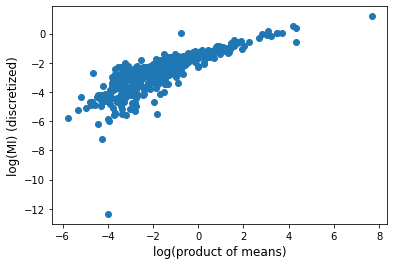

In [28]:
plt.scatter(np.log(mean_prod), np.log(mi))
plt.xlabel('log(product of means)')
plt.ylabel('log(MI) (discretized)')

In [119]:
a1 = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['NTg8-TAGAGAGCGGCGCGCCTAC']), 'STAT1'].X.todense().A1
b1 = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['NTg8-TAGAGAGCGGCGCGCCTAC']), 'IFI6'].X.todense().A1

a2 = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['STAT1g2-CATCCTTTGGTACAACATG']), 'STAT1'].X.todense().A1
b2 = adata[(adata.obs['treatment']=='tx') & adata.obs['guide_ID'].isin(['STAT1g2-CATCCTTTGGTACAACATG']), 'IFI6'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [120]:
print(mutual_info_score(a1,b1))
print(stats.linregress(a1,b1))

1.889455517371665
LinregressResult(slope=0.38736605292759485, intercept=4.984548370436305, rvalue=0.29146487075352157, pvalue=0.03248652595643263, stderr=0.1763013592934382, intercept_stderr=2.3671553158493097)


In [121]:
print(mutual_info_score(a2,b2))
print(stats.linregress(a2,b2))

0.46216784402223854
LinregressResult(slope=0.8656134658725922, intercept=0.8416713417865864, rvalue=0.6475062807845307, pvalue=9.261187562827323e-12, stderr=0.10985504943712984, intercept_stderr=0.4102050206803798)


### STAT1 Sanity check

In [43]:
select_genes = []
for g in list(set(thp1_isgs) - set([tf])):
    if 'IFI' in g or 'OAS' in g or 'ISG' in g or 'MX' in g:
        select_genes.append(g)

In [139]:
ctrl_moments

,mean,variance,rv,gene
0,0.083160,0.015423,0.832866,LINC01409
1,0.105062,0.026820,1.120011,LINC01128
2,0.342579,0.074953,0.673477,NOC2L
3,4.697294,29.640535,3.154371,ISG15
4,0.101715,0.028461,1.232854,AGRN
...,...,...,...,...
9038,27.025358,195.730713,0.722577,MT-ND4L
9039,17.610172,109.458496,0.927899,MT-ND4
9040,11.686849,46.008240,0.862419,MT-ND5
9041,2.522758,6.892960,2.305474,MT-ND6


In [157]:
g_ko = 'STAT1'
tf = 'IRF9'
targets = list(set(thp1_isgs) - set([tf]))#['ISG15', 'IFIT1', 'MX1', 'OASL', 'GBP1', 'GBP4']
genes = targets + [tf]
subset = adata[(adata.obs['treatment']=='tx') & (
               adata.obs['gene'].isin([g_ko]) |
               (
                    adata.obs['gene'].isin(['NT']) & (
                    adata.obs['guide_ID'].str.contains('g1') |
                    adata.obs['guide_ID'].str.contains('g2') | 
                    adata.obs['guide_ID'].str.contains('g3') | 
                    adata.obs['guide_ID'].str.contains('g4'))))
                    ].copy().copy()
subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)
memento.create_groups(subset, label_columns=['is_ko'])
memento.compute_1d_moments(subset, min_perc_group=.7)
targets = list(set(targets) & set(subset.var.index))
genes = targets + [tf]
memento.compute_2d_moments(subset, list(itertools.product([tf], targets))   )
# memento.compute_2d_moments(subset,   )
ctrl_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^0']).T, columns=['mean', 'variance', 'rv'])
ctrl_moments.index = subset.var.index.tolist()
ctrl_moments = ctrl_moments.loc[genes]
stim_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^1']).T, columns=['mean', 'variance', 'rv'])
stim_moments.index = subset.var.index.tolist()
stim_moments = stim_moments.loc[genes]

ctrl_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^0'])
ctrl_moments_2d.index = targets
ctrl_moments_2d = ctrl_moments_2d.join(ctrl_moments)
ctrl_moments_2d['rv_1'] = ctrl_moments.loc[tf,'rv']
ctrl_moments_2d['mean_1'] = ctrl_moments.loc[tf,'mean']

ctrl_moments_2d['beta'] = ctrl_moments_2d['cov']/ctrl_moments_2d['var_1']
ctrl_moments_2d['resbeta'] = ctrl_moments_2d['corr']*ctrl_moments_2d['rv']/ctrl_moments_2d['rv_1']
ctrl_moments_2d['rescov'] = ctrl_moments_2d['cov']/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])

stim_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^1'])
stim_moments_2d.index = targets
stim_moments_2d = stim_moments_2d.join(stim_moments)
stim_moments_2d['rv_1'] = stim_moments.loc[tf,'rv']
stim_moments_2d['mean_1'] = stim_moments.loc[tf,'mean']

stim_moments_2d['beta'] = stim_moments_2d['cov']/stim_moments_2d['var_1']
stim_moments_2d['resbeta'] = stim_moments_2d['corr']*stim_moments_2d['rv']/stim_moments_2d['rv_1']
stim_moments_2d['rescov'] = stim_moments_2d['cov']/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])

print(subset.obs['is_ko'].value_counts())

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0    1275
1     406
Name: is_ko, dtype: int64


In [158]:
select_genes = []
for g in targets:
    if 'IFI' in g or 'OAS' in g or 'ISG' in g or 'MX' in g or 'HLA' in g:
        select_genes.append(g)

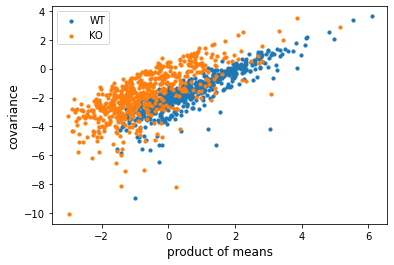

In [159]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
plt.xlabel('product of means')
plt.ylabel('covariance')
plt.legend(['WT', 'KO'])

In [163]:
wt_fit

LinregressResult(slope=0.8812883671046996, intercept=-2.605903426540591, rvalue=0.7761665802893046, pvalue=0.0, stderr=0.01601657561662384, intercept_stderr=0.04017375312085927)

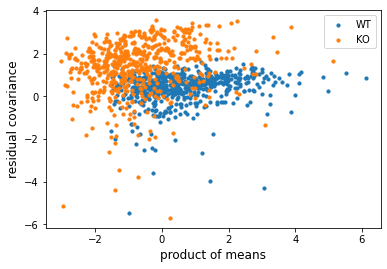

In [165]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)) - (wt_fit[0]*np.log(a)+wt_fit[1]), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)) - (ko_fit[0]*np.log(a)+ko_fit[1]), s=10)
plt.xlabel('product of means')
plt.ylabel('residual covariance')
plt.legend(['WT', 'KO'])

In [166]:
ctrl_moments_2d.head(5)

,cov,corr,var_1,var_2,mean,variance,rv,rv_1,mean_1,beta,resbeta,rescov
CRELD1,0.094471,0.105461,0.885248,0.906469,0.583075,0.906469,3.646456,0.758143,1.484286,0.106718,0.507238,0.056818
S100A10,1.082706,0.038182,0.885248,908.328857,32.148949,908.328857,2.394767,0.758143,1.484286,1.223054,0.120606,0.803533
FGD2,0.194515,0.248497,0.885248,0.692148,0.886725,0.692148,1.418072,0.758143,1.484286,0.219729,0.464802,0.187598
PSMB10,0.862742,0.382598,0.885248,5.743965,4.003698,5.743965,0.823561,0.758143,1.484286,0.974577,0.415612,1.091837
RCAN1,0.073116,0.036779,0.885248,4.464422,0.594207,4.464422,17.433626,0.758143,1.484286,0.082594,0.845738,0.020112


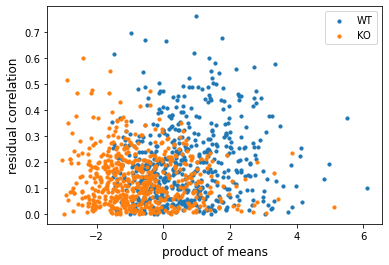

In [173]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['corr']/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])
plt.scatter(np.log(a),np.abs(b), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['corr']/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])
plt.scatter(np.log(a),np.abs(b), s=10)
plt.xlabel('product of means')
plt.ylabel('residual correlation')
plt.legend(['WT', 'KO'])

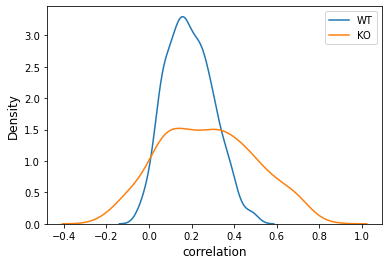

In [172]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['corr']#/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])
sns.kdeplot(b)
a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['corr']#/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])
sns.kdeplot(b)
plt.xlabel('correlation')
plt.legend(['WT', 'KO'])

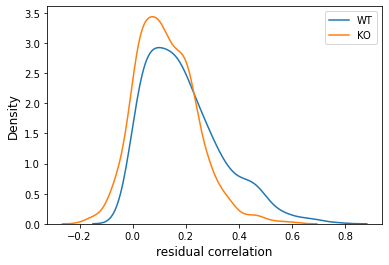

In [170]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['corr']/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])
sns.kdeplot(b)
a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['corr']/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])
sns.kdeplot(b)
plt.xlabel('residual correlation')
plt.legend(['WT', 'KO'])

### Random pairs of genes

In [112]:
ctrl_moments.head(5)

,mean,variance,rv,gene_1,gene_2
0,0.083160,0.015423,0.832866,LINC01409,LINC01409
1,0.105062,0.026820,1.120011,LINC01128,LINC01128
2,0.342579,0.074953,0.673477,NOC2L,NOC2L
3,4.697294,29.640535,3.154371,ISG15,ISG15
4,0.101715,0.028461,1.232854,AGRN,AGRN


In [118]:
stim_moments_2d.head(5)

,cov,corr,var_1,var_2,gene_1,gene_2,mean,variance,rv,gene_2_1,mean_1,variance_1,rv_1,gene_1_1
0,0.006896,0.065034,0.217799,0.051630,DHPS,UTP20,0.634454,0.217799,0.766910,DHPS,0.160969,0.051630,1.293442,UTP20
1,0.064438,0.268827,0.580330,0.099005,VPS29,NUDT2,1.366663,0.580330,0.573244,VPS29,0.513809,0.099005,0.484826,NUDT2
2,0.001710,0.021580,0.127806,0.049148,CDA,ATG9A,0.223744,0.127806,2.084799,CDA,0.217972,0.049148,0.830354,ATG9A
3,0.048501,0.097668,0.048553,5.079136,RP2,GSDMD,0.196318,0.048553,0.942392,RP2,1.654619,5.079136,3.599478,GSDMD
4,0.030851,0.219664,0.060061,0.328425,G6PC3,IPO7,0.317127,0.060061,0.603239,G6PC3,0.955714,0.328425,0.594373,IPO7


In [145]:
g_ko = 'STAT1'
tf = 'STAT2'
targets = list(set(thp1_isgs) - set([tf]))#['ISG15', 'IFIT1', 'MX1', 'OASL', 'GBP1', 'GBP4']
genes = targets + [tf]
subset = adata[(adata.obs['treatment']=='tx') & (
               adata.obs['gene'].isin([g_ko]) |
               (
                    adata.obs['gene'].isin(['NT']) & (
                    adata.obs['guide_ID'].str.contains('g1') |
                    adata.obs['guide_ID'].str.contains('g2') | 
                    adata.obs['guide_ID'].str.contains('g3') | 
                    adata.obs['guide_ID'].str.contains('g4'))))
                    ].copy().copy()
subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)
memento.create_groups(subset, label_columns=['is_ko'])
memento.compute_1d_moments(subset, min_perc_group=.7)
targets = list(set(targets) & set(subset.var.index))
genes = targets + [tf]
# memento.compute_2d_moments(subset, list(itertools.product([tf], targets))   )
g1 = np.random.choice(subset.var.index, 2000)
g2 = np.random.choice(subset.var.index, 2000)
memento.compute_2d_moments(subset, list(zip(g1, g2)))
ctrl_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^0']).T, columns=['mean', 'variance', 'rv'])
ctrl_moments['gene_1'] = subset.var.index.tolist()
ctrl_moments['gene_2'] = subset.var.index.tolist()
stim_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^1']).T, columns=['mean', 'variance', 'rv'])
stim_moments['gene_1'] = subset.var.index.tolist()
stim_moments['gene_2'] = subset.var.index.tolist()

ctrl_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^0'])
ctrl_moments_2d['gene_1'] = g1
ctrl_moments_2d['gene_2'] = g2
ctrl_moments_2d = ctrl_moments_2d.merge(ctrl_moments, on='gene_1', suffixes=('', '_1')).merge(ctrl_moments, on='gene_2', suffixes=('', '_1'))

# ctrl_moments_2d['rv_1'] = ctrl_moments.loc[tf,'rv']
# ctrl_moments_2d['mean_1'] = ctrl_moments.loc[tf,'mean']

# ctrl_moments_2d['beta'] = ctrl_moments_2d['cov']/ctrl_moments_2d['var_1']
# ctrl_moments_2d['resbeta'] = ctrl_moments_2d['corr']*ctrl_moments_2d['rv']/ctrl_moments_2d['rv_1']
# ctrl_moments_2d['rescov'] = ctrl_moments_2d['cov']/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])

stim_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^1'])
stim_moments_2d['gene_1'] = g1
stim_moments_2d['gene_2'] = g2
stim_moments_2d = stim_moments_2d.merge(stim_moments, on='gene_1', suffixes=('', '_1')).merge(stim_moments, on='gene_2', suffixes=('', '_1'))

# stim_moments_2d['rv_1'] = stim_moments.loc[tf,'rv']
# stim_moments_2d['mean_1'] = stim_moments.loc[tf,'mean']

# stim_moments_2d['beta'] = stim_moments_2d['cov']/stim_moments_2d['var_1']
# stim_moments_2d['resbeta'] = stim_moments_2d['corr']*stim_moments_2d['rv']/stim_moments_2d['rv_1']
# stim_moments_2d['rescov'] = stim_moments_2d['cov']/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])

print(subset.obs['is_ko'].value_counts())

0    1275
1     406
Name: is_ko, dtype: int64


In [146]:
stim_moments_2d.head(5)

,cov,corr,var_1,var_2,gene_1,gene_2,mean,variance,rv,gene_2_1,mean_1,variance_1,rv_1,gene_1_1
0,0.069989,0.220107,3.727247,0.027127,ELOVL1,ZC3H3,3.394535,3.727247,0.725246,ELOVL1,0.255079,0.027127,0.370101,ZC3H3
1,-0.038946,-0.048550,0.076521,8.409195,ZBTB1,ENO1,0.253030,0.076521,1.055659,ZBTB1,4.774987,8.409195,0.867825,ENO1
2,-0.090166,-0.231734,0.018003,8.409195,ZNF414,ENO1,0.169593,0.018003,0.422195,ZNF414,4.774987,8.409195,0.867825,ENO1
3,0.028254,0.321802,0.258901,0.029776,COPS6,TIPIN,0.703732,0.258901,0.772704,COPS6,0.135308,0.029776,0.924238,TIPIN
4,-0.023750,-0.285967,0.049664,0.138880,FMNL3,AAMP,0.175510,0.049664,1.114754,FMNL3,0.471420,0.138880,0.776034,AAMP


In [152]:
wt_fit

LinregressResult(slope=0.8812883671046996, intercept=-2.605903426540591, rvalue=0.7761665802893046, pvalue=0.0, stderr=0.01601657561662384, intercept_stderr=0.04017375312085927)

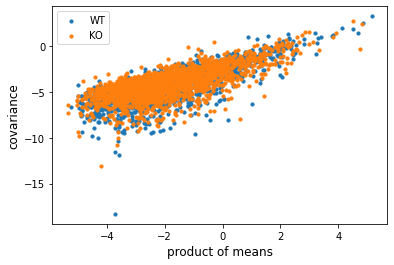

In [153]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
wt_fit = stats.linregress(np.log(a),np.log(np.abs(b)))

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['cov']
ko_fit = stats.linregress(np.log(a),np.log(np.abs(b)))

plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
plt.xlabel('product of means')
plt.ylabel('covariance')
plt.legend(['WT', 'KO'])

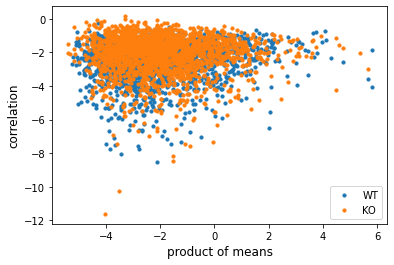

In [130]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['corr']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['corr']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
plt.xlabel('product of means')
plt.ylabel('correlation')
plt.legend(['WT', 'KO'])

### ISGs

In [131]:
g_ko = 'STAT1'
tf = 'STAT2'
targets = list(set(thp1_isgs) - set([tf]))#['ISG15', 'IFIT1', 'MX1', 'OASL', 'GBP1', 'GBP4']
genes = targets + [tf]
subset = adata[(adata.obs['treatment']=='tx') & (
               adata.obs['gene'].isin([g_ko]) |
               (
                    adata.obs['gene'].isin(['NT']) & (
                    adata.obs['guide_ID'].str.contains('g1') |
                    adata.obs['guide_ID'].str.contains('g2') | 
                    adata.obs['guide_ID'].str.contains('g3') | 
                    adata.obs['guide_ID'].str.contains('g4'))))
                    ].copy().copy()
subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)
memento.create_groups(subset, label_columns=['is_ko'])
memento.compute_1d_moments(subset, min_perc_group=.7)
targets = list(set(targets) & set(subset.var.index))
genes = targets + [tf]
# memento.compute_2d_moments(subset, list(itertools.product([tf], targets))   )
g1 = np.random.choice(targets, len(targets))
g2 = np.random.choice(targets, len(targets))
memento.compute_2d_moments(subset, list(zip(g1, g2)))
ctrl_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^0']).T, columns=['mean', 'variance', 'rv'])
ctrl_moments['gene_1'] = subset.var.index.tolist()
ctrl_moments['gene_2'] = subset.var.index.tolist()
stim_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^1']).T, columns=['mean', 'variance', 'rv'])
stim_moments['gene_1'] = subset.var.index.tolist()
stim_moments['gene_2'] = subset.var.index.tolist()

ctrl_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^0'])
ctrl_moments_2d['gene_1'] = g1
ctrl_moments_2d['gene_2'] = g2
ctrl_moments_2d = ctrl_moments_2d.merge(ctrl_moments, on='gene_1', suffixes=('', '_1')).merge(ctrl_moments, on='gene_2', suffixes=('', '_1'))

# ctrl_moments_2d['rv_1'] = ctrl_moments.loc[tf,'rv']
# ctrl_moments_2d['mean_1'] = ctrl_moments.loc[tf,'mean']

# ctrl_moments_2d['beta'] = ctrl_moments_2d['cov']/ctrl_moments_2d['var_1']
# ctrl_moments_2d['resbeta'] = ctrl_moments_2d['corr']*ctrl_moments_2d['rv']/ctrl_moments_2d['rv_1']
# ctrl_moments_2d['rescov'] = ctrl_moments_2d['cov']/np.sqrt(ctrl_moments_2d['rv']*ctrl_moments_2d['rv_1'])

stim_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^1'])
stim_moments_2d['gene_1'] = g1
stim_moments_2d['gene_2'] = g2
stim_moments_2d = stim_moments_2d.merge(stim_moments, on='gene_1', suffixes=('', '_1')).merge(stim_moments, on='gene_2', suffixes=('', '_1'))

# stim_moments_2d['rv_1'] = stim_moments.loc[tf,'rv']
# stim_moments_2d['mean_1'] = stim_moments.loc[tf,'mean']

# stim_moments_2d['beta'] = stim_moments_2d['cov']/stim_moments_2d['var_1']
# stim_moments_2d['resbeta'] = stim_moments_2d['corr']*stim_moments_2d['rv']/stim_moments_2d['rv_1']
# stim_moments_2d['rescov'] = stim_moments_2d['cov']/np.sqrt(stim_moments_2d['rv']*stim_moments_2d['rv_1'])

print(subset.obs['is_ko'].value_counts())

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0    1275
1     406
Name: is_ko, dtype: int64


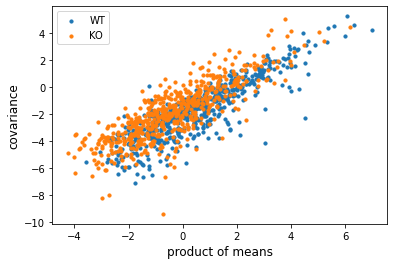

In [132]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['cov']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
plt.xlabel('product of means')
plt.ylabel('covariance')
plt.legend(['WT', 'KO'])

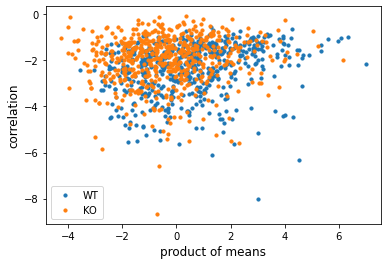

In [133]:
a = ctrl_moments_2d['mean']*ctrl_moments_2d['mean_1']
b = ctrl_moments_2d['corr']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)

a = stim_moments_2d['mean']*stim_moments_2d['mean_1']
b = stim_moments_2d['corr']
plt.scatter(np.log(a),np.log(np.abs(b)), s=10)
plt.xlabel('product of means')
plt.ylabel('correlation')
plt.legend(['WT', 'KO'])

In [69]:
tau_prime

IFITM1     3.792549
OASL       0.677473
IFI6       4.084124
IFI30     11.704710
ISG15      1.970254
IFIT3      1.988852
OAS3       1.153110
OAS1       0.545205
OAS2       0.583394
IFITM3    10.722706
IFI16      1.063539
IFI44      0.506687
IFIH1      0.847112
MX1        2.246057
ISG20      1.221888
IFI27      6.515215
IFI35      2.300781
IFI44L     1.611699
dtype: float64

In [53]:
ctrl_moments_2d.loc[select_genes]

,cov,corr,var_1,var_2,mean,variance,rv,rv_1,mean_1,beta,resbeta,rescov
IFITM1,0.648004,0.149248,0.835325,22.567421,5.114479,22.567421,2.022876,0.654707,1.560683,0.775751,0.461138,0.563079
OASL,0.049545,0.063961,0.835325,0.718308,0.712651,0.718308,2.120702,0.654707,1.560683,0.059312,0.207180,0.042047
IFI6,3.159613,0.336895,0.835325,105.298737,10.675975,105.298737,2.312492,0.654707,1.560683,3.782496,1.189947,2.567853
IFI30,18.151489,0.257026,0.835325,5970.540527,89.620834,5970.540527,2.152888,0.654707,1.560683,21.729858,0.845186,15.288958
ISG15,1.337502,0.288262,0.835325,25.772675,4.529153,25.772675,2.903891,0.654707,1.560683,1.601175,1.278557,0.970020
IFIT3,0.356634,0.160792,0.835325,5.889283,2.653188,5.889283,1.785691,0.654707,1.560683,0.426940,0.438553,0.329834
OAS3,0.328723,0.203245,0.835325,3.131580,1.856672,3.131580,1.806107,0.654707,1.560683,0.393527,0.560682,0.302298
OAS1,0.414579,0.479239,0.835325,0.895889,1.352581,0.895889,0.901169,0.654707,1.560683,0.496309,0.659647,0.539735
OAS2,0.143009,0.264808,0.835325,0.349149,0.915944,0.349149,0.681812,0.654707,1.560683,0.171202,0.275771,0.214047
IFITM3,3.252892,0.291137,0.835325,149.448059,17.867298,149.448059,1.209563,0.654707,1.560683,3.894164,0.537871,3.655373


In [54]:
stim_moments_2d.loc[select_genes]

,cov,corr,var_1,var_2,mean,variance,rv,rv_1,mean_1,beta,resbeta,rescov
IFITM1,1.485832,0.505001,0.625721,13.834885,1.569513,13.834885,10.736640,2.34745,0.614119,2.374594,2.309744,0.295963
OASL,0.273766,0.630425,0.625721,0.301378,0.211301,0.301378,5.491399,2.34745,0.614119,0.437521,1.474756,0.076250
IFI6,2.896188,0.577930,0.625721,40.134918,3.531067,40.134918,7.194861,2.34745,0.614119,4.628565,1.771338,0.704721
IFI30,7.309811,0.160819,0.625721,3301.855713,51.176998,3301.855713,3.471071,2.34745,0.614119,11.682229,0.237796,2.560803
ISG15,1.576373,0.480007,0.625721,17.236204,1.607118,17.236204,12.831349,2.34745,0.614119,2.519292,2.623758,0.287227
IFIT3,0.847891,0.588359,0.625721,3.319057,0.830188,3.319057,7.630807,2.34745,0.614119,1.355063,1.912566,0.200335
OAS3,0.559669,0.571055,0.625721,1.535064,0.638683,1.535064,5.408768,2.34745,0.614119,0.894440,1.315770,0.157067
OAS1,0.506226,0.703909,0.625721,0.826561,0.529635,0.826561,3.918470,2.34745,0.614119,0.809028,1.174996,0.166912
OAS2,0.268913,0.597681,0.625721,0.323522,0.329284,0.323522,3.152372,2.34745,0.614119,0.429765,0.802620,0.098854
IFITM3,5.545306,0.697224,0.625721,101.094025,6.509533,101.094025,5.736133,2.34745,0.614119,8.862272,1.703709,1.511185


### Mediation

In [139]:
ko_genes = ['JAK2', 'IFNGR1', 'IFNGR2','STAT1', 'IRF1']

In [142]:
mediation_effects = {}
for g_ko in ko_genes:
    mediation_effects[g_ko] = {}
    subset = adata.copy().copy()
    subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)

    memento.create_groups(subset, label_columns=['is_ko'])

    memento.compute_1d_moments(subset, min_perc_group=.7)
    # memento.compute_2d_moments(subset, list(itertools.product(['STAT1', 'STAT2'],['ISG15', 'OAS1', 'OAS2','IFI6', 'MX1', 'MX2', 'GBP1', 'HLA-DRA']))   )
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_ko',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        resampling='permutation',
        approx=False,
        num_cpus=94)
    df = memento.get_1d_ht_result(subset)

    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    de_genes = df.query('de_fdr < 0.05 & de_coef < -0.5').gene.tolist()
    de_tfs = list(set(tf_list) & set(de_genes))

    for tf in ko_genes:
        if tf == g_ko: continue

        targets = list(set(subset.var.index.tolist()) & set(de_genes) - set([tf]))
        # targets = ['GBP1', ]
        genes = [tf] + targets
        memento.compute_2d_moments(subset, list(itertools.product([tf], targets))   )

        moments = memento.get_2d_moments(subset, groupby='is_ko')

        ctrl_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^0']).T, columns=['mean', 'variance', 'rv'])
        ctrl_moments.index = subset.var.index.tolist()
        ctrl_moments = ctrl_moments.loc[genes]
        stim_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^1']).T, columns=['mean', 'variance', 'rv'])
        stim_moments.index = subset.var.index.tolist()
        stim_moments = stim_moments.loc[genes]

        ctrl_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^0'])
        ctrl_moments_2d.index = targets
        stim_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^1'])
        stim_moments_2d.index = targets

        tau = stim_moments['mean'][targets] - ctrl_moments['mean'][targets]
        tf_tau = stim_moments['mean'][tf] - ctrl_moments['mean'][tf]
        beta_stim = stim_moments_2d['cov']/stim_moments_2d['var_1']
        alpha_stim = stim_moments['mean'][targets] - beta_stim*stim_moments['mean'][tf]
        beta_ctrl = ctrl_moments_2d['cov']/ctrl_moments_2d['var_1']
        alpha_ctrl = ctrl_moments['mean'][targets] - beta_ctrl*ctrl_moments['mean'][tf]
        tau_prime = alpha_stim - alpha_ctrl
        sobel = (tau.abs()-tau_prime.abs())/tau.abs()
        mediation_effects[g_ko][tf] = sobel.copy()
        print(g_ko, tf, sobel.mean())

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.0s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:    5.1s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:    6.8s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:    9.0s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:   11.1s
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:   13.7s
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:   16.8s
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:   20.5s
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:   24.2s
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:   28.5s
[Parallel(n_j

JAK2 IFNGR1 0.1707876543587378
JAK2 IFNGR2 0.2504721247823415
JAK2 STAT1 0.3278423872338933
JAK2 IRF1 0.49795562756114714


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=94)]: Done 340 tasks      | elapsed:    1.8s
[Parallel(n_jobs=94)]: Done 1031 tasks      | elapsed:    4.8s
[Parallel(n_jobs=94)]: Done 1530 tasks      | elapsed:    6.7s
[Parallel(n_jobs=94)]: Done 2082 tasks      | elapsed:    8.9s
[Parallel(n_jobs=94)]: Done 2732 tasks      | elapsed:   11.4s
[Parallel(n_jobs=94)]: Done 3482 tasks      | elapsed:   14.8s
[Parallel(n_jobs=94)]: Done 4332 tasks      | elapsed:   18.2s
[Parallel(n_jobs=94)]: Done 5282 tasks      | elapsed:   21.9s
[Parallel(n_jobs=94)]: Done 6332 tasks      | elapsed:   26.2s
[Parallel(n_jobs=94)]: Done 7482 tasks      | elapsed:   31.0s
[Parallel(n_jobs=94)]: Done 8732 tasks      | elapsed:   36.1s
[Parallel(n_jobs=94)]: Done 9088 out of 9088 | elapsed:   39.8s finished


IFNGR1 JAK2 0.3776827685664616
IFNGR1 IFNGR2 0.2707664742870064
IFNGR1 STAT1 0.3314617911667676
IFNGR1 IRF1 0.5024775478180896


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=94)]: Done 340 tasks      | elapsed:    1.9s
[Parallel(n_jobs=94)]: Done 1034 tasks      | elapsed:    5.2s
[Parallel(n_jobs=94)]: Done 1530 tasks      | elapsed:    7.3s
[Parallel(n_jobs=94)]: Done 2082 tasks      | elapsed:    9.7s
[Parallel(n_jobs=94)]: Done 2732 tasks      | elapsed:   12.4s
[Parallel(n_jobs=94)]: Done 3482 tasks      | elapsed:   16.1s
[Parallel(n_jobs=94)]: Done 4332 tasks      | elapsed:   20.0s
[Parallel(n_jobs=94)]: Done 5282 tasks      | elapsed:   24.1s
[Parallel(n_jobs=94)]: Done 6332 tasks      | elapsed:   28.7s
[Parallel(n_jobs=94)]: Done 7482 tasks      | elapsed:   33.9s
[Parallel(n_jobs=94)]: Done 8732 tasks      | elapsed:   39.6s
[Parallel(n_jobs=94)]: Done 9093 out of 9093 | elapsed:   43.5s finished


IFNGR2 JAK2 0.3351025791629705
IFNGR2 IFNGR1 0.2225171652935503
IFNGR2 STAT1 0.2826870678997886
IFNGR2 IRF1 0.4802481418904425


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=94)]: Done 340 tasks      | elapsed:    1.6s
[Parallel(n_jobs=94)]: Done 1036 tasks      | elapsed:    4.4s
[Parallel(n_jobs=94)]: Done 1623 tasks      | elapsed:    6.5s
[Parallel(n_jobs=94)]: Done 2176 tasks      | elapsed:    8.4s
[Parallel(n_jobs=94)]: Done 2826 tasks      | elapsed:   10.7s
[Parallel(n_jobs=94)]: Done 3576 tasks      | elapsed:   13.9s
[Parallel(n_jobs=94)]: Done 4426 tasks      | elapsed:   17.1s
[Parallel(n_jobs=94)]: Done 5376 tasks      | elapsed:   20.5s
[Parallel(n_jobs=94)]: Done 6426 tasks      | elapsed:   24.4s
[Parallel(n_jobs=94)]: Done 7576 tasks      | elapsed:   28.6s
[Parallel(n_jobs=94)]: Done 8826 tasks      | elapsed:   33.4s
[Parallel(n_jobs=94)]: Done 9086 out of 9086 | elapsed:   36.3s finished


STAT1 JAK2 0.34193845072005324
STAT1 IFNGR1 0.27548226928777414
STAT1 IFNGR2 0.3501124686696521
STAT1 IRF1 0.37409947781357134


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=94)]: Done 340 tasks      | elapsed:    1.9s
[Parallel(n_jobs=94)]: Done 1033 tasks      | elapsed:    5.4s
[Parallel(n_jobs=94)]: Done 1531 tasks      | elapsed:    7.4s
[Parallel(n_jobs=94)]: Done 2082 tasks      | elapsed:   10.0s
[Parallel(n_jobs=94)]: Done 2732 tasks      | elapsed:   12.7s
[Parallel(n_jobs=94)]: Done 3482 tasks      | elapsed:   16.4s
[Parallel(n_jobs=94)]: Done 4332 tasks      | elapsed:   20.3s
[Parallel(n_jobs=94)]: Done 5282 tasks      | elapsed:   24.4s
[Parallel(n_jobs=94)]: Done 6332 tasks      | elapsed:   29.2s
[Parallel(n_jobs=94)]: Done 7482 tasks      | elapsed:   34.3s
[Parallel(n_jobs=94)]: Done 8732 tasks      | elapsed:   40.0s
[Parallel(n_jobs=94)]: Done 9134 out of 9134 | elapsed:   44.2s finished


IRF1 JAK2 0.16543681418507772
IRF1 IFNGR1 0.05955465336002374
IRF1 IFNGR2 0.1479643306945895
IRF1 STAT1 0.3609217417218928


In [143]:
heatmap = pd.DataFrame(columns=ko_genes, index=ko_genes)

In [144]:
for g_ko in ko_genes:
    for tf in ko_genes:
        if g_ko == tf: continue
        heatmap.loc[g_ko, tf] = mediation_effects[g_ko][tf].mean()

Text(33.0, 0.5, 'Experiment KO')

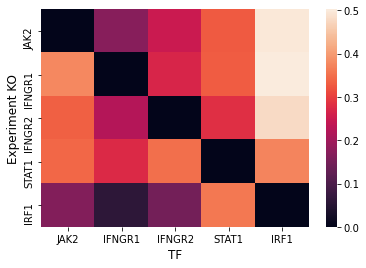

In [147]:
sns.heatmap(heatmap.fillna(0))
plt.xlabel('TF'); plt.ylabel('Experiment KO')

In [131]:
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

In [132]:
de_genes = df.query('de_fdr < 0.05 & de_coef < -0.5').gene.tolist()

In [133]:
de_tfs = list(set(tf_list) & set(de_genes))

In [134]:
tf = 'IRF1'

targets = list(set(subset.var.index.tolist()) & set(de_genes) - set([tf]))
# targets = ['GBP1', ]
genes = [tf] + targets
memento.compute_2d_moments(subset, list(itertools.product([tf], targets))   )

moments = memento.get_2d_moments(subset, groupby='is_ko')

In [135]:
ctrl_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^0']).T, columns=['mean', 'variance', 'rv'])
ctrl_moments.index = subset.var.index.tolist()
ctrl_moments = ctrl_moments.loc[genes]
stim_moments = pd.DataFrame(np.vstack(subset.uns['memento']['1d_moments']['sg^1']).T, columns=['mean', 'variance', 'rv'])
stim_moments.index = subset.var.index.tolist()
stim_moments = stim_moments.loc[genes]

ctrl_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^0'])
ctrl_moments_2d.index = targets
stim_moments_2d = pd.DataFrame(subset.uns['memento']['2d_moments']['sg^1'])
stim_moments_2d.index = targets


In [136]:
tau = stim_moments['mean'][targets] - ctrl_moments['mean'][targets]
tf_tau = stim_moments['mean'][tf] - ctrl_moments['mean'][tf]
beta_stim = stim_moments_2d['cov']/stim_moments_2d['var_1']
alpha_stim = stim_moments['mean'][targets] - beta_stim*stim_moments['mean'][tf]
beta_ctrl = ctrl_moments_2d['cov']/ctrl_moments_2d['var_1']
alpha_ctrl = ctrl_moments['mean'][targets] - beta_ctrl*ctrl_moments['mean'][tf]
tau_prime = alpha_stim - alpha_ctrl
sobel = (tau.abs()-tau_prime.abs())/tau.abs()

# sobel = (tau-np.clip(tau_prime, a_min=0, a_max=tau))/tau

In [137]:
print('JAK2 KO', 'IRF1 mediation')
print(sobel.sort_values(ascending=False).mean())

JAK2 KO IRF1 mediation
0.5024775478180896


In [138]:
print('IRF1 KO', 'JAK2 mediation')
print(sobel.sort_values(ascending=False).mean())

IRF1 KO JAK2 mediation
0.5024775478180896


In [104]:
sobel.sort_values(ascending=False).mean()

0.3748747070125631

In [96]:
sobel.sort_values(ascending=False).mean()

0.3536723447915945

### Get JAK/STAT dependent TFs

In [18]:
g_ko = 'STAT1'
subset = adata.copy().copy()
subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)

memento.create_groups(subset, label_columns=['is_ko'])

memento.compute_1d_moments(subset, min_perc_group=.7)

available_genes = list(set(subset.var.index.tolist()) & set(thp1_isgs))
available_tfs = list(set(filtered_tfs) & set(subset.var.index))
# memento.compute_2d_moments(subset, list(itertools.product(['STAT1', 'STAT2'],['ISG15', 'OAS1', 'OAS2','IFI6', 'MX1', 'MX2', 'GBP1', 'HLA-DRA']))   )
memento.compute_2d_moments(subset, list(itertools.product(['STAT1'], available_genes))   )

moments = memento.get_2d_moments(subset, groupby='is_ko')

In [19]:
moments['diff'] = moments['is_ko_1'] - moments['is_ko_0']


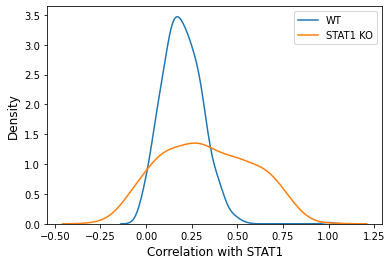

In [22]:
sns.kdeplot(moments['is_ko_0'])

sns.kdeplot(moments['is_ko_1'])
plt.xlabel('Correlation with STAT1');
plt.legend(['WT', 'STAT1 KO'])

In [21]:
moments['diff'] = moments['is_ko_1'] - moments['is_ko_0']
ranking = moments.groupby('gene_1')['diff'].mean().sort_values(ascending=False)

In [48]:
moments.query('gene_1 == "IRF9" & gene_2 == "MX2"')

,gene_1,gene_2,is_ko_0,is_ko_1,diff


In [53]:
ranking['IRF9']

-0.031025440141640354

### Run 2D memento for transcription factors

In [54]:
done_files = os.listdir(data_path + '2d_tf/')
for g in filtered_tfs:
    
    for g_ko in ['NT', 'STAT1', 'JAK2', 'IFNGR1', 'CUL3']:
        print(g, g_ko)
        
        if g == g_ko or g == 'NT' or g_ko == 'NT': continue
        fname = '{}_with_{}_KO_isg.h5ad'.format(g, g_ko)
        if fname in done_files: continue
        
        subset = adata.copy().copy()

        subset = adata[adata.obs['gene'].isin(['NT', g_ko]) & (adata.obs['treatment']=='tx')].copy().copy()
    
        subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g_ko).values.astype(int)

        memento.create_groups(subset, label_columns=['is_ko', 'replicate'])
        
        memento.compute_1d_moments(subset, min_perc_group=.7)
        
        if g not in subset.var.index: continue
        available_genes = list(set(subset.var.index.tolist()) & set(thp1_isgs))
        memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )
#         moments = memento.get_2d_moments(subset, groupby='is_ko')
#         available_genes = moments.query('is_ko_0 > 0.2 | is_ko_0 < -0.2').gene_2.tolist()
#         memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )
        
        print(g, g_ko, len(available_genes))
        memento.ht_2d_moments( 
            subset, 
            formula_like='1 + is_ko + replicate',
            treatment_col='is_ko', 
            num_boot=10000, 
            verbose=1,
            num_cpus=94,
            resampling='permutation',
            approx=True)
        
        subset.write(data_path + '2d_tf/{}_with_{}_KO_isg.h5ad'.format(g, g_ko))

In [59]:
'STAT1' in filtered_tfs

True

In [60]:
tf = 'STAT1'
g_ko = 'STAT1'
subset = sc.read(data_path + '2d_tf/{}_with_{}_KO_isg.h5ad'.format(tf, g_ko))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data_volume/memento/eccite/2d_tf/STAT1_with_STAT1_KO_isg.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Check TF's correlation to other genes following KO

In [123]:
# subset_ko_genes = ['STAT1', 'STAT2', 'JAK2', 'CUL3', 'IFNGR1', 'IFNGR2', 'MYC', 'SMAD4']
done_files = os.listdir(data_path + '/2d/')
for g in ['JAK2']:#ko_genes:
    
    if g == 'NT': continue
    fname = '{}_with_{}_KO_guide_rep.h5ad'.format(g, g)
#         if fname in done_files: continue

    subset = adata.copy().copy()

    subset = adata[adata.obs['gene'].isin(['NT', g])].copy().copy()

    subset.obs['is_ko'] = subset.obs.guide_ID.str.contains(g).values

    memento.create_groups(subset, label_columns=['is_ko', 'replicate', 'guide_ID'])

    memento.compute_1d_moments(subset, min_perc_group=.7)

    if g not in subset.var.index: continue

    available_genes = list(set(subset.var.index))

    if len(available_genes) < 10: continue
    memento.compute_2d_moments(subset, list(itertools.product([g], available_genes))   )

    memento.ht_2d_moments( 
        subset, 
        formula_like='1 + is_ko + replicate',
        treatment_col='is_ko', 
        num_boot=10000, 
        verbose=1,
        num_cpus=14,
        resampling='bootstrap',
        approx=False)

    subset.write(data_path + '2d/{}_with_{}_KO_guide_rep.h5ad'.format(g, g))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:106: RuntimeWarning: divide by zero encountered in log
  rv[cond] = np.exp(np.log(var[cond]) - f(np.log(mean[cond])))


In [124]:
moments, counts = memento.get_2d_moments(subset)

In [131]:
results['IFNGR1'].query('gene == "IFNGR1"')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr
3183,IFNGR1,-0.150763,0.045791,0.001701,0.199772,0.201333,0.314369,0.006115,0.849193


In [127]:
dv_genes = results['JAK2'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

In [120]:
subset.obs['STAT1'] = subset[:, 'STAT1'].X.todense().A1
subset.obs['GBP4'] = subset[:, 'GBP4'].X.todense().A1

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [70]:
dv_genes = results['STAT1'].query('dv_fdr < 0.1 & dv_coef > 0').gene.tolist()

### Debugging
